In [171]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.prebuilt import ToolNode
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from langchain_community.document_loaders import TextLoader
from langchain import hub
import textwrap
import operator
import os

In [172]:
llm= ChatOllama(model="llama3.2")

In [173]:
class RouterSchema(BaseModel):
    datasource: Literal["vectorstore", "tools", "unknown"] = Field(
        description="Given a user question choose to route it to tools search or a vectorstore.",
    )
structured_llm_router=llm.with_structured_output(RouterSchema)
datasource= structured_llm_router.invoke('how are you')
print(datasource)
# system = """You are an expert at routing a user question to a vectorstore or tool search. You have access to these tools {tools}
# The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
# Use the vectorstore for questions on these topics. Otherwise, use web-search."""
# route_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system),
#         ("human", "{question}"),
#     ]
# )

# question_router = route_prompt | structured_llm_router
# datasource=question_router.invoke(
#         {"question": "What is the admin"}
#     ).datasource
# print(datasource)



datasource='unknown'


In [174]:
class AppState(TypedDict):
    datasource: Literal["vectorstore","tools", "unknown"]
    question: str
    answer:str
    context:List[Document]
   

In [175]:
@tool
def add(a: int, b: int):
    """Addition of two numbers"""
    print("a", a, "b", b)
    return "Addition is "+ a * b
@tool
def retrieve_admin(user: str) -> str:
    """Returns the fixed admin name 'Ahmad' regardless of the user"""
    return "Ahmad"
tools = [add, retrieve_admin]
tool_node = ToolNode(tools)

In [176]:
def retriever(state:AppState)->AppState:
    base_dir = os.getcwd()
    product_file_path = os.path.join(base_dir, "./product_help.txt")
    product_loader = TextLoader(product_file_path)
    product_docs = product_loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=300,
            chunk_overlap=50
        )
    product_chunks = text_splitter.split_documents(product_docs)
    for doc in product_chunks:
            doc.metadata["type"] = "product"
    docs=product_chunks
    embeddings = OllamaEmbeddings(
            model="mxbai-embed-large",
            base_url="http://10.28.85.206:11434/"
        )
    vectorstore = Chroma.from_documents(
            documents=docs,
            embedding=embeddings,
            persist_directory="chroma_db",
        )
    vectorstore.persist()
    retrieved_docs = vectorstore.similarity_search(state["question"], k=5)
    print("retrieved_docs", retrieved_docs)
    return {"context":retrieved_docs}

In [ ]:
def router(state: AppState) -> AppState:
    print("retrieved data", state["context"])
    system = f"""You are an expert at routing a user question to a vectorstore or tool calling.
    The vectorstore contains documents related to GL website and accounting question.
    Use the vectorstore for questions on these topics and if the user question related to the tools then return the tools. 
    If the user question not related to the both of the document and tools then return the unknown
    User Question:
    {state['question']}

    Retrieved Context:
    {state['context']}

    Available Tools:
    {tools}
    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )
    question_router = route_prompt | structured_llm_router
    print(
    question_router.invoke(
        {"question": state["question"]}
    )
)
    return {"datasource":question_router}
#     prompt = f"""
# You are a smart routing agent that decides where a user's question should be routed:

# 1. Return "vectorstore" if the question is asking for information that could be answered from the documents (related to the GL website or accounting results).
# 2. Return "tools" if the question is asking to perform an action that matches one of the defined tools.
# 3. Return "unknown" if the question is off-topic, too vague, personal, or unrelated (e.g., "How are you?", "Tell me a joke", "What's your name?").

# Examples:
# - "What is a general ledger?" → vectorstore
# - "Add 2 and 3" → tools
# - "Retrieve admin user" → tools
# - "What are accounting results?" → vectorstore
# - "How's the weather?" → unknown
# - "Hello, are you there?" → unknown

# User Question:
# {state['question']}

# Retrieved Context:
# {state['context']}

# Available Tools:
# {tools}
# """
#     datasource = structured_llm_router.invoke(prompt).datasource
#     print("datasource12", datasource)
#     return {"datasource": datasource}


In [178]:
def generate_via_document(state:AppState):

    rag_prompt=f"""
        You are a helpful assistant for GL accounting website. Use only the provided text files knowledge base to answer user questions accurately.

        Answer requirements:
        1. Quote exact figures/dates when available
        2. Reference relevant forms/regulations where applicable
        3. Keep answers under 3 sentences unless technical details require more
        4. Add the anchor tag with attribute target="_blank" if any link is provided
        5. Only use the link which is provided in the knowledge text file not other then else.


        If the question is not related to either accounting or GL website, reply:
        "Please ask a question related to accounting or GL website."

        Context: {state["context"]}
        Question: {state["question"]}
        Concise accounting answer:
        """
    answer=llm.invoke(rag_prompt)
    return {'answer': answer}
    

In [179]:
def check_condition(state: AppState) -> Literal["generate_via_tool", "generate_via_document","unknown"]:
    datasource = state["datasource"]
    if datasource == "tools":
        return "generate_via_tool"
    elif datasource == "vectorstore":
        return "generate_via_document"
    else:
        return "unknown"



In [180]:
def generate_via_tool(state:AppState):
    question=state["question"]
    tool_calling_model=llm.bind_tools(tool_node)
    answer=tool_calling_model.invoke({"question":question})
    print("generate_via_tool_answer",answer)
    return {"answer":answer}

In [181]:
def unknown_node(state:AppState):
    unknown_prompt = f"""
You are a helpful assistant integrated into a system that answers user questions either by:

1. Searching through uploaded documents (related to the GL website or accounting results).
2. Performing actions using defined {tools} for accounting or business operations.

However, the current user question does **not** appear to match either category. It seems unrelated to both the uploaded content and the available tools.

---

## Instructions:

Kindly inform the user that their question cannot be answered because it is outside the scope of this assistant. Use natural, conversational, and polite language. Gently guide the user to ask questions related to the available domains.

---

## Available Domains:
- **GL Website**
- **Accounting results**
- **Related business operations supported by tools**

---

## Example Tone:
- Friendly and conversational
- Encouraging redirection, not rejection
- Short, clear, and non-technical

---

## Response Format:
Write a friendly and professional response **as if you were speaking to the user**. Do not mention tools or vector stores or system internals. Just explain clearly that the system only supports questions about the GL website or accounting results.

---

## Now generate the final message to return to the user based on this context.
"""
    answer=llm.invoke(unknown_prompt).content
    print("unknown_node answer", answer)
    return {"answer": answer}
    

In [182]:
# create graph
graph=StateGraph(AppState)

# Define the nodes

graph.add_node("retrieve", retriever)
graph.add_node("router", router)
# graph.add_node("llm",generate)
graph.add_node("generate_via_tool",generate_via_tool)
graph.add_node("generate_via_document", generate_via_document)
graph.add_node("unknown", unknown_node)
# Add edges
graph.add_edge(START, "retrieve")
graph.add_edge("retrieve","router")
graph.add_conditional_edges("router",check_condition)
# graph.add_conditional_edges("agent", check_condition)
graph.add_edge("generate_via_tool", END)
graph.add_edge("generate_via_document", END)
graph.add_edge("unknown", END)

# Compile graph

workflow=graph.compile()


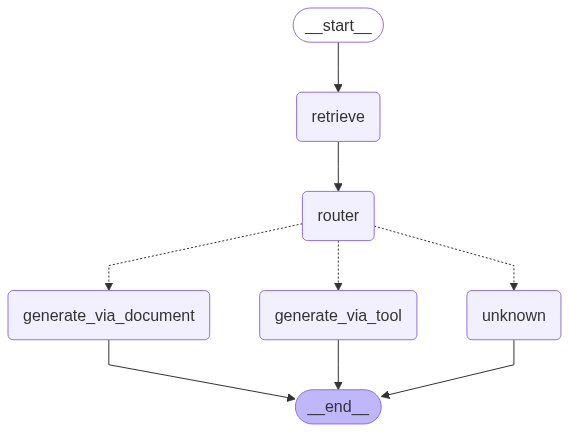

In [183]:
workflow


In [185]:
answer=workflow.invoke({"question":"Plese give login URL"})

retrieved_docs [Document(metadata={'type': 'product', 'source': '/home/muhammadahmad/Downloads/chatboot/product_help.txt'}, page_content='5. How do I login to the system?\nTo login to the system, go to <a href="https://gl.vteamslabs.com/login" target="_blank">https://gl.vteamslabs.com/login</a>, enter your email and password, and click Login.'), Document(metadata={'source': '/home/muhammadahmad/Downloads/chatboot/product_help.txt', 'type': 'product'}, page_content='5. How do I login to the system?\nTo login to the system, go to <a href="https://gl.vteamslabs.com/login" target="_blank">https://gl.vteamslabs.com/login</a>, enter your email and password, and click Login.'), Document(metadata={'type': 'product', 'source': '/home/muhammadahmad/Downloads/chatboot/product_help.txt'}, page_content='5. How do I login to the system?\nTo login to the system, go to <a href="https://gl.vteamslabs.com/login" target="_blank">https://gl.vteamslabs.com/login</a>, enter your email and password, and clic

KeyError: 'Input to ChatPromptTemplate is missing variables {"\'source\'", "\'type\'"}.  Expected: ["\'source\'", "\'type\'", \'question\'] Received: [\'question\']\nNote: if you intended {\'source\'} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\'source\'}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

In [170]:
answer["answer"]

"Hi there, I'm happy to help you with your question! Unfortunately, it seems like your question might not be something I can assist with directly. The system I'm a part of is focused on helping with information about the GL website and accounting results.\n\nIf you have questions about what's available on the GL website or how to interpret accounting results, I'd be happy to try and help. However, if you're looking for something outside of those topics, it might not be possible for me to provide a helpful answer.\n\nWould you mind asking another question that falls under one of our main areas of focus?"